In [1]:
import numpy as np
import sqlite3
import math
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import matplotlib

/data/users/darren/miniconda3/envs/rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 讓 matplotlib 可正確顯示中文字型
# 首先，取得系統中所有的字型
fm = matplotlib.font_manager.FontManager()
mat_fonts = set(f.name for f in fm.ttflist)
# 如果系統中有微軟正黑體(Microsoft JhengHei)就用它 (Windows/Linux)
if 'Microsoft JhengHei' in mat_fonts:
    matplotlib.rc('font', family='Microsoft JhengHei')
# 如果系統中有黑體(Heiti TC)就用它 (macOS)
if 'Heiti TC' in mat_fonts:
    matplotlib.rc('font', family='Heiti TC')

In [3]:
# 讀取 BGE-M3 的 tokenizer
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3")

In [4]:
# 連接資料庫
conn = sqlite3.connect("./financial_laws.db")

# 查詢出來的結果 (tuple)，變成 key-value 型式 (dict)
conn.row_factory = sqlite3.Row

# 建立 cursor
cursor = conn.cursor()

'''
資料表名稱:
laws_full -> 法律/法規的所有條文
laws_part -> 法律/法規的某個條文
laws_sent  -> 法律/法規的特定條文的某一句話
'''

# 定義 SQL 語法
table_name = 'laws_full'
sql = f'''
SELECT content
FROM {table_name};
'''

# 取得連線資料庫進行查詢的物件
stmt = cursor.execute(sql)

# 計算每一則法規內容的 tokens
list_count = []
for index, record in enumerate(stmt.fetchall()):
    # 取得當前文字內容的 tokens
    tokens = tokenizer.encode(record['content'])

    # 加入 list，用來計算 token 數量
    list_count.append(len(tokens))

# 檢視最大與最小的 tokens 數量
print('資料數量: ', index + 1)
print('最大 Tokens: ', max(list_count))
print('最小 Tokens: ', min(list_count))

# 關閉資料庫資源
conn.close()


Token indices sequence length is longer than the specified maximum sequence length for this model (13470 > 8192). Running this sequence through the model will result in indexing errors


資料數量:  151
最大 Tokens:  33652
最小 Tokens:  68


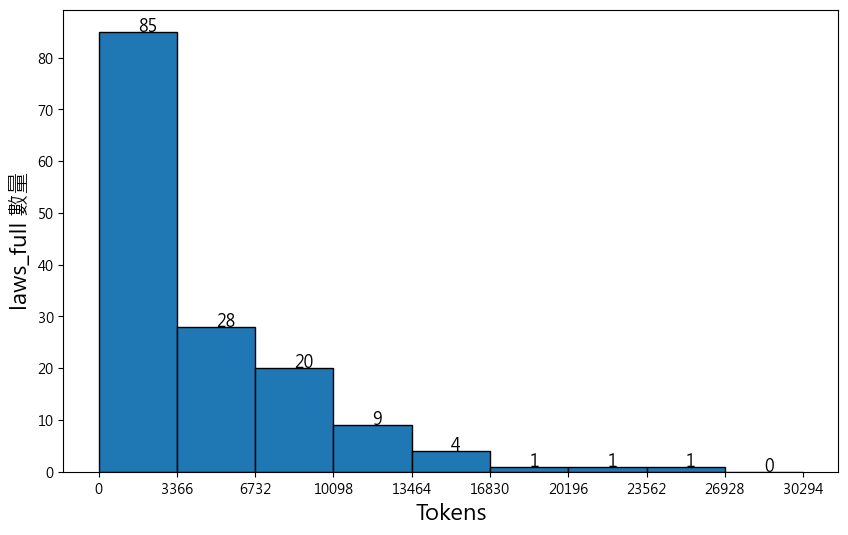

In [5]:
# 組距 (將成績 0 到 100 分，分成 10 個組距，回傳 11 個數字)
x_bins = np.arange(0, max(list_count), math.ceil(max(list_count) / 10))

# 設定輸出圖片的寬、高和解析度
plt.figure(figsize=(10, 6), dpi=100)

# 繪製直方圖 (會回傳每個組距當中的資料數量，以及組距列表)
arr_counts, arr_bins, obj = plt.hist(
    list_count,
    bins=x_bins,
    edgecolor='black',
    linewidth=1
)

# 設定數值文字在圖表上
for i in range(len(arr_counts)):
    plt.text(
        arr_bins[i] + int(x_bins[1]) / 2,
        arr_counts[i],
        arr_counts[i].astype('int16'),
        fontsize=12
    )

# 設定標題
plt.xticks(x_bins, rotation=0, fontsize=10)
plt.ylabel(f'{table_name} 數量', fontsize=16)
plt.xlabel('Tokens', fontsize=16)

# 顯示圖表
plt.show()

In [6]:
# 刪除 tokenizer 所使用變數
del tokenizer